# Computer vision Lab

# Your first application in Computer Vision
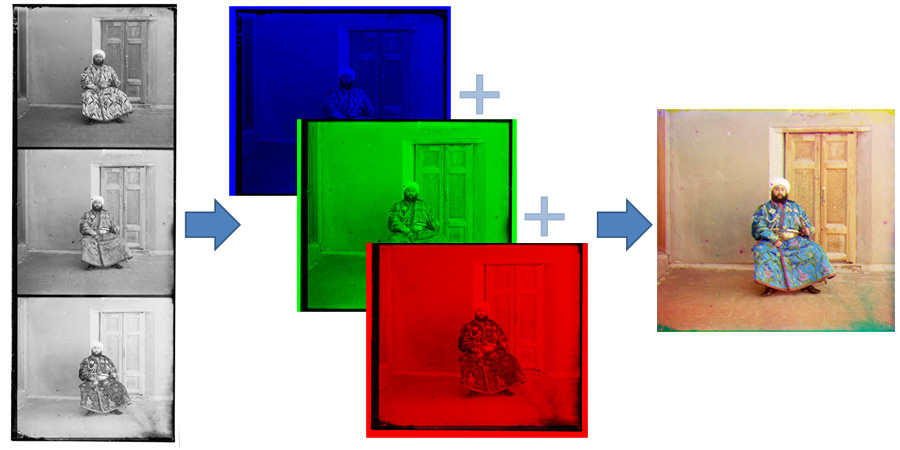

Sergei Mikhailovich Prokudin-Gorskii (1863-1944) was a photographer ahead of his time. He saw color photography as the wave of the future and came up with a simple idea to produce color photos: record three exposures of every scene onto a glass plate using a red, a green, and a blue filter and then project the monochrome pictures with correctly coloured light to reproduce the color image; color printing of photos was very difficult at the time. Due to the fame he received from his color photos, including the only color portrait of Leo Tolstoy (a famous Russian author), he won the Tzar's permission and funding to travel across the Russian Empire and document it in 'color' photographs. His RGB glass plate negatives were purchased in 1948 by the Library of Congress. They are now digitized and available [on-line](http://www.loc.gov/pictures/search/?q=Prokudin+negative&sp=2&st=grid).

A few of the digitized glass plate images (both hi-res and low-res versions) will be placed in the following directory (note that the filter order from top to bottom is BGR, not RGB!): data/. 

Your program will take a **glass plate image** as input and produce a **single color image** as output. The program should *divide the image into three equal parts* and **align the second and the third parts (G and R) to the first (B)**. For each image, you will need to print the (x,y) displacement vector that was used to align the parts.

The easiest way to align the parts is to exhaustively search over a window of possible displacements (say [-15,15] pixels), score each one using some image matching metric, and take the displacement with the best score. There is a number of possible metrics that one could use to score how well the images match. 
- The simplest one is just the L2 norm also known as the Sum of Squared Differences (SSD) distance which is simply sum(sum((image1-image2).^2)) where the sum is taken over the pixel values. 

- Another is normalized cross-correlation (NCC), which is simply a dot product between two normalized vectors: (image1./||image1|| and image2./||image2||).

<font color='red'>**Important!**</font> Note that in the case of the Emir of Bukhara (show above), the images to be matched do not actually have the same brightness values (they are different color channels), so you might have to use a cleverer metric, or *different features than the raw pixels*.

Exhaustive search will become prohibitively expensive if the pixel displacement is too large (which will be the case for high-resolution glass plate scans). In this case, you will need to implement a faster search procedure such as an image pyramid. An image pyramid represents the image at multiple scales (usually scaled by a factor of 2) and the processing is done sequentially starting from the coarsest scale (smallest image) and going down the pyramid, updating your estimate as you go. It is very easy to implement by adding recursive calls to your original single-scale implementation. 

Take the digitized Prokudin-Gorskii glass plate images and automatically produce a color image with as few visual artifacts as possible. Your program should:

- Divide the image into three equal parts and align the three color channels (blue is top, green is middle, red is bottom).
- Implement a single-scale sliding window alignment search with an appropriate metric, and record the displacement vector used to align the parts.
- The high-resolution images are quite large—for efficiency, implement a multiscale image pyramid alignment algorithm. Report any difference between the single- and multi-scale alignment vectors, plus the speedup factor of the multi-scale approach.
- Try your algorithm on other images from the collection (*data folder*).


In [1]:
import os
import cv2 as cv
import pdb
import numpy as np
import matplotlib.pyplot as plt

In [2]:
##### define metrics
def mean_ssd(image_1, image_2) -> float:
    """
     This function receives two matrices having the same dimension and returns the mean of squared differences them.
    :param image_1. The first matrix
    :param image_2. The second matrix
    :return float. The mean of squared differences.
    """  
    return ((image_1-image_2)**2).mean() 

# define metrics
def nnc(image_1, image_2) -> float:
    """
     This function receives two matrix having the same dimension and returns the normalized cross-correlation.
     The normalized cross-correlation is simply a dot product between two normalized vectors: 
     (image_1./||image_1|| and image_2./||image_2||)
    :param image_1. The first matrix
    :param image_2. The second matrix
    :return float. The normalized cross-correlation.
    """ 
    
    image_1 = image_1.reshape(-1)
    image_2 = image_2.reshape(-1).transpose()
    return np.dot(image_1 / np.linalg.norm(image_1), image_2 / np.linalg.norm(image_2))

assert mean_ssd(np.array([[1, 2, 3], [4, 5, 6]]), np.array([[2, 3, 4], [5, 6, 7]])) == 1
assert nnc(np.matrix([[1, 2, 3], [4, 5, 6]]), np.matrix([[2, 3, 4], [5, 6, 7]])) > 0.99
nnc(np.random.rand(5, 5), np.random.rand(5, 5)) # isn't this too big for two random matrices?

0.6737085780428227

In [3]:
def displace(img, i, j):
    img = img[-i:, :] if i <= 0 else img[:-i, :]
    img = img[:, -j:] if j <= 0 else img[:, :-j]
    return img

def allign_channel(channel_1, blue_channel, window_i:tuple = (-15, 15), window_j:tuple = (-15, 15), metric:callable=mean_ssd) -> tuple: 
    
    """
    It returns (pos_i, pos_j) which is the best alignment of channel_1 with blue_channel.
    :param channel_1. This is the channel that will be alligned to the blue one.
    :param blue_channel
    :window_i:tuple. The start and end position on the y axis.
    :window_j:tuple. The start and end position on the x axis.
    :return (pos_i, pos_j) which is the best alignment of channel_1 with blue_channel
    """
    pos_i = 0; pos_j = 0
    min_error = None

    li, hi = window_i
    lj, hj = window_j
    
    for i in range(li, hj + 1):
        for j in range(lj, hj + 1):
            error = metric(displace(channel_1, i, j), displace(blue_channel, -i, -j))
            if min_error is None or error < min_error:
                min_error = error
                pos_i, pos_j = i, j
                
    return pos_i, pos_j

In [4]:
def split_channels(image) -> tuple:
    """
    It receives the glass plate image and split it into bgr channels.
    :image a glass plate image with b, g and r channels.
    :return tuple b, g and r channels.
    """
    height, width = image.shape 
    height = height // 3
    b = image[:height] 
    g = image[height: 2 * height]
    r = image[2 * height: 3 * height]
    
    return b, g, r

In [5]:
def get_edges(image, threshold1: int = 100, threshold2: int = 200):
    """
    It receives a grayscale image and returns the edges using Canny algorithm.
    :image a gray scale image
    :threshold1: low threshold. Any gradient bellow this value will be discarded. 
    :threshold2: high threshold. Any gradient higher this value will be kept. 
    :return an nd-array containg the edges of the image.
    """
    gradients = cv.Canny(image, threshold1, threshold2) 
    return gradients
    

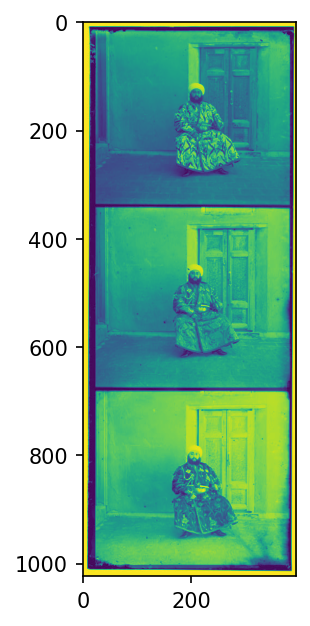

In [6]:
# read and display the first image
image = cv.imread(os.path.join('data', '00153v.jpg'), cv.IMREAD_GRAYSCALE)
plt.figure(dpi=150)
plt.imshow(image)

(341, 394) (341, 394) (341, 394)


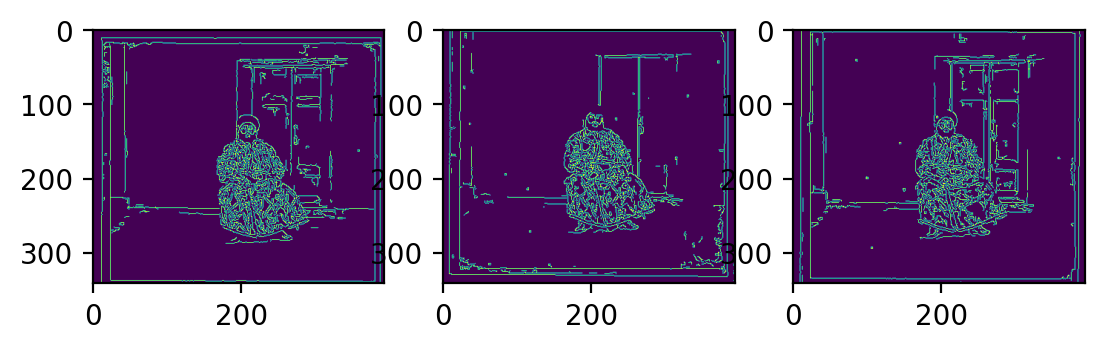

In [7]:
# separate color channels 
b, g, r = split_channels(image)

# apply Canny edge detector 
b_ = get_edges(b)
r_ = get_edges(r)
g_ = get_edges(g)
plt.figure(dpi=200)
plt.subplot(1, 3, 1)
plt.imshow(b_)
plt.subplot(1, 3, 2)
plt.imshow(r_) 
plt.subplot(1, 3, 3)
plt.imshow(g_)
print(b.shape, r.shape, g.shape)  

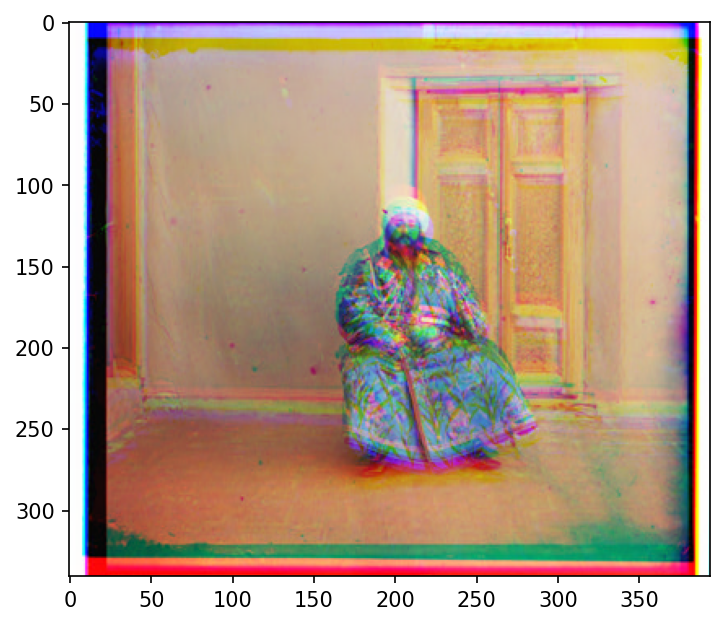

In [8]:
# concatenating channels without alligment
im_out = np.dstack([r, g, b])
plt.figure(dpi=150)
plt.imshow(im_out)

In [9]:
window_size = 20
i_r, j_r = allign_channel(r_, b_, window_i=(-window_size, window_size),  window_j=(-window_size, window_size)) 
i_g, j_g = allign_channel(g_, b_, window_i=(-window_size, window_size),  window_j=(-window_size, window_size)) 


In [10]:
print(i_r, j_r)
print(i_g, j_g)

14 4
7 2


In [11]:
def create_color_image(b, g, r, i_r, j_r, i_g, j_g):
    """
    Received b, g, r from the glass plate image and the coordinates to allign the channels and returns the color image.
    :param b - blue channel
    :param g - green channel
    :param r - red channel
    :param i_r - the coordinate for the red channel on the y axis.
    :param j_r - the coordinate for the red channel on the x axis.
    :param i_g - the coordinate for the green channel on the y axis.
    :param j_g - the coordinate for the green channel on the x axis. 
    :return the color image.
    """
    height, width = image.shape 
    height = height // 3
    window_size = max(np.abs([i_r, j_r, i_g, j_g])) 
    color_image = 255 * np.ones((height + window_size * 2, width + window_size * 2, 3), np.uint8) 
    color_image[window_size:window_size + height, window_size:window_size + width, 0] = b

    color_image[i_g + window_size: i_g + window_size + height, j_g + window_size: j_g + window_size + width, 1] = g
    color_image[i_r + window_size: i_r + window_size + height, j_r + window_size: j_r + window_size + width, 2] = r
    return color_image


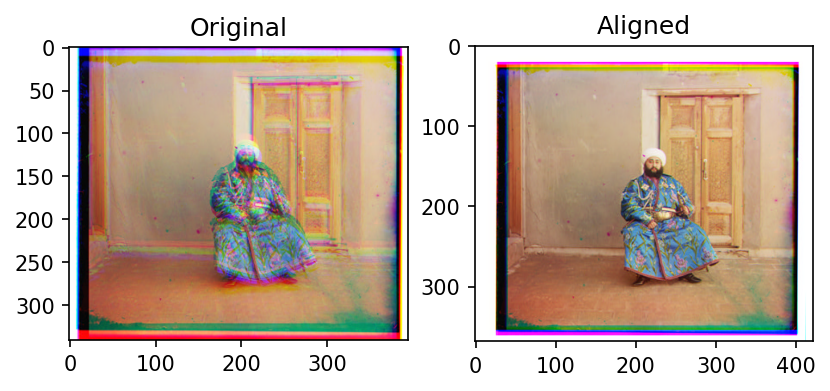

In [12]:
original_image = create_color_image(b, g, r, 0, 0, 0, 0)
aligned_image = create_color_image(b, g, r, i_r, j_r, i_g, j_g)


plt.figure(dpi=150)
plt.subplot(1, 2, 1)
plt.title('Original')
plt.imshow(np.uint8(original_image)[:, :, ::-1])
plt.subplot(1, 2, 2)
plt.title('Aligned')
plt.imshow(np.uint8(aligned_image)[:, :, ::-1])

In [13]:
window_size = 20
i_r, j_r = allign_channel(r_, b_, window_i=(-window_size, window_size),  window_j=(-window_size, window_size), metric=nnc) 
i_g, j_g = allign_channel(g_, b_, window_i=(-window_size, window_size),  window_j=(-window_size, window_size), metric=nnc) 

In [14]:
print(i_r, j_r)
print(i_g, j_g)

-20 -18
-20 9


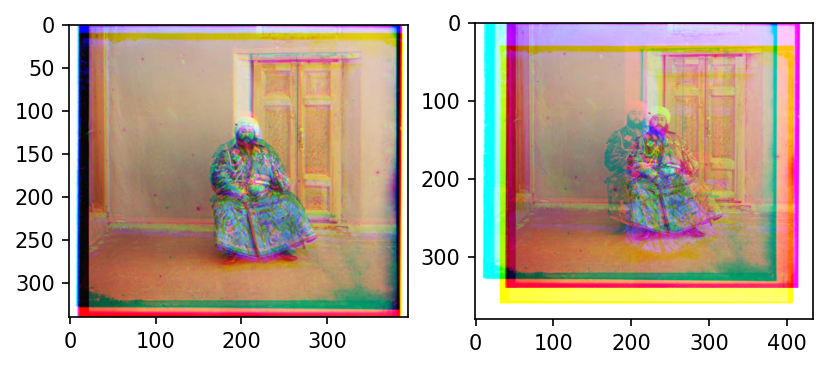

In [15]:
original_image = create_color_image(b, g, r, 0, 0, 0, 0)
aligned_image = create_color_image(b, g, r, i_r, j_r, i_g, j_g)


plt.figure(dpi=150)
plt.subplot(1, 2, 1)
plt.imshow(np.uint8(original_image)[:, :, ::-1])
plt.subplot(1, 2, 2)
plt.imshow(np.uint8(aligned_image)[:, :, ::-1])

 ### Creating the pyramid

In the multi-level implementation we first build an image pyramid for each color channel. This means the original image is stored at a number of different scales, each one half the size of the previous. 
The shrinking can be done by resizing the image. Once we have the pyramid the alignment operation is first performed on the *smallest scale image* and the *resulting offset used as the starting point for alignment on the next size up*. The process is repeated all the way down the pyramid until we have the optimal offset for the original image. This allows the region of offsets we consider at each level to be much smaller, in this case ±4 pixels, as we have an approximate guess from the previous level and at the smallest level ±2 pixels is a significant portion of the image. This is most significant at the larger levels where there are lots of pixels to consider when calculating the alignment score. Overall this method is much faster than the naive implementation on large images.

In [16]:
# read and display the first image
image = cv.imread(os.path.join('data', '01043u.tif'), cv.IMREAD_GRAYSCALE) 
cv.imshow('image', cv.resize(image, None, fx=0.2, fy=0.2)) # resize the image because it does not fit the screen
cv.waitKey(0) # wait untill any keypress 
cv.destroyAllWindows() # close the window

In [17]:
def create_pyramid_level(image, scale: int):
    """
    It creates a pyramid level by resizing the image based on the scale and returns the edges of the pyramid level.
    :param image 
    :param scale - it is the level of the pyramid.
    :return edges of the pyramid level. 
    """
    r = 1 / (2 ** scale)
    resized = cv.resize(image, (0, 0), fx=r, fy=r)
    borders = get_edges(resized)
    return borders

In [18]:
def allign_image_using_pyramid(image, max_pyramid_level: int, window_size: int, step: int) -> tuple:
    """
    It returns (pos_i_r, pos_j_r) which is the best alignment of red channel with blue_channel and (pos_i_g, pos_j_g) 
    which is the best alignment of green channel with blue_channel.
    :param image - glass plate image 
    :max_pyramid_level - how many times the image will be resized by a factor of 2.
    :window_size - how many pixels will be tried in the first iteration.
    :step - how many pixels will be tried in the next iterations (except the first one).
    :return the best alignment for red channel and green channel.
    """
    # separate color channels 
    b, g, r = split_channels(image)
    
    # creates each level of the pyramid for each channel
    pyramid_r = [create_pyramid_level(r, i) for i in range(max_pyramid_level)]
    pyramid_b = [create_pyramid_level(b, i) for i in range(max_pyramid_level)]
    pyramid_g = [create_pyramid_level(g, i) for i in range(max_pyramid_level)] 
        
    window_i_r = (-window_size - step, window_size + step)
    window_j_r = (-window_size - step, window_size + step)
    window_i_g = (-window_size - step, window_size + step)
    window_j_g = (-window_size - step, window_size + step)

    for i in range(max_pyramid_level - 1, -1, -1):    
        i_r, j_r = allign_channel(pyramid_r[i], pyramid_b[i], window_i=window_i_r, window_j=window_j_r)
        window_i_r = (i_r * 2 - step, i_r * 2 + step)
        window_j_r = (j_r * 2 - step, j_r * 2 + step)
        i_g, j_g = allign_channel(pyramid_g[i], pyramid_b[i], window_i=window_i_g, window_j=window_j_g)
        window_i_g = (i_g * 2 - step, i_g * 2 + step)
        window_j_g = (j_g * 2 - step, j_g * 2 + step)
        print(window_i_r, window_j_r)
        print(window_i_g, window_j_g)
    return i_r, j_r, i_g, j_g

In [19]:
i_r, j_r, i_g, j_g = allign_image_using_pyramid(image, max_pyramid_level=5, window_size=15, step=4)

(-2, 6) (-2, 6)
(-6, 2) (-4, 4)
(-2, 6) (0, 8)
(-8, 0) (-2, 6)
(2, 10) (4, 12)
(-12, -4) (-2, 6)
(10, 18) (10, 18)
(-14, -6) (2, 10)
(22, 30) (24, 32)
(-22, -14) (16, 24)


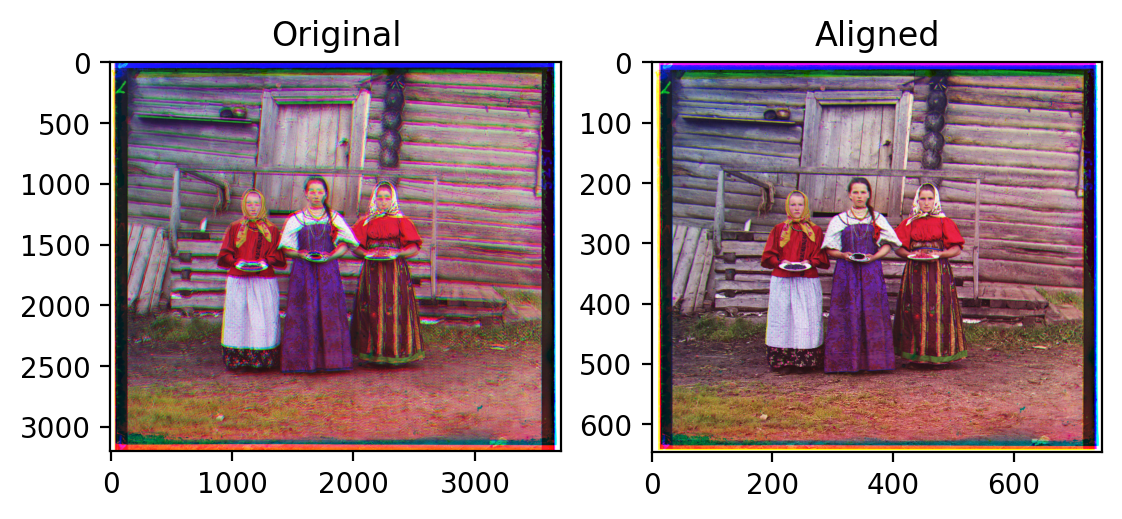

In [20]:
b, g, r = split_channels(image)
color_image_big = create_color_image(b, g, r, i_r, j_r, i_g, j_g)
original = create_color_image(b, g, r,0, 0, 0, 0)

plt.figure(dpi=200)
plt.subplot(1, 2, 1)
plt.title('Original')
plt.imshow(original[:, :, ::-1])
plt.subplot(1, 2, 2)
plt.title('Aligned')
plt.imshow(cv.resize(np.uint8(color_image_big), (0, 0), fx=0.2, fy=0.2)[:, :, ::-1])